## Homework 5.4 

a)
combine the title and abstract. 

bigrams are sequences of 2 words. 
unigrams are single words.
Therefore, the tokens are twice as long for text that is tokenized into bigrams

In [37]:
import nltk
import re
from typing import List, Set
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation

In [38]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
# Include punctuation in the stop words set
# Additional punctuation
stop_words.update({'...', '``', "''"})




documents = []
with open('scopusabstracts.csv', 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split('#')
        if len(parts) == 3:
            doc_id, title, abstract = parts
            combined_text = title + ' ' + abstract
            documents.append(combined_text)
# deleting the title thingy
documents = documents[1:]

[nltk_data] Downloading package stopwords to /home/praita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/praita/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [39]:
for doc in documents[:10]:
    print(doc)

Anomaly detection in wide area imagery [Geniş alan görüntülerinde anomali tespiti] This study is about detecting anomalies in wide area imagery collected from an aircraft. The set of anomalies have been identified as anything out of the normal course of action. For this purpose, two different data sets were used and the experiments were carried out on these data sets. For anomaly detection, a convolutional neural network model that tries to generate the next image using past images is designed. The images were pre-processed before being given to the model. Anomaly detection is performed by comparing the estimated image and the true image.
Person re-identification with deep kronecker-product matching and group-shuffling random walk Person re-identification (re-ID) aims to robustly measure visual affinities between person images. It has wide applications in intelligent surveillance by associating same persons' images across multiple cameras. It is generally treated as an image retrieval 

In [40]:

class Preprocessor:
    def __init__(self, documents: List[str], custom_stopwords: Set[str] = None):
        """
        Initializes the Preprocessor with a list of documents and an optional set of custom stopwords.
        
        :param documents: List of raw text documents.
        :param custom_stopwords: Set of additional stopwords to include.
        """
        self.documents = documents
        self.tokens_list: List[List[str]] = []
        self.cleaned_tokens_list: List[List[str]] = []
        self.cleaned_documents: List[str] = []
        
        # Initialize stop words
        self.stop_words: Set[str] = set(stopwords.words('english'))
        if custom_stopwords:
            self.stop_words.update(custom_stopwords)
        # Include punctuation and additional symbols in stop words
        self.stop_words.update(set('''!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'''))
        self.stop_words.update({'...', '``', "''"})
        
        # Initialize stemmer
        self.stemmer = PorterStemmer()
    
    def tokenize_documents(self) -> List[List[str]]:
        """Tokenizes the documents and converts tokens to lowercase."""
        self.tokens_list = [word_tokenize(doc.lower()) for doc in self.documents]
        return self.tokens_list
    
    def remove_stopwords(self) -> List[List[str]]:
        """Removes stopwords from the tokenized documents."""
        if not self.tokens_list:
            self.tokenize_documents()
        self.tokens_list = [
            [token for token in tokens if token not in self.stop_words]
            for tokens in self.tokens_list
        ]
        return self.tokens_list
    
    def remove_numbers(self) -> List[List[str]]:
        """Removes numbers and non-alphabetic tokens from the tokenized documents."""
        self.tokens_list = [
            # here, the regular expression package re, substitutes all 
            # r'\d+': This is a regular expression pattern where \d matches any digit (0-9), 
            # and + means "one or more" of the preceding 
            [re.sub(r'\d+', '', token) for token in tokens]
            for tokens in self.tokens_list
        ]
        self.tokens_list = [
            [token for token in tokens if token.isalpha()]
            for tokens in self.tokens_list
        ]
        return self.tokens_list
    
    def stem_tokens(self) -> List[List[str]]:
        """Applies stemming to the tokens."""
        self.tokens_list = [
            [self.stemmer.stem(token) for token in tokens]
            for tokens in self.tokens_list
        ]
        return self.tokens_list
    
    def preprocess(self) -> List[str]:
        """
        Runs the full preprocessing pipeline:
        Tokenization -> Lowercasing -> Stopword Removal -> Number Removal -> Stemming
        """
        self.tokenize_documents()
        self.remove_numbers()
        # self.remove_stopwords()
        self.stem_tokens()
        # joins the tokes from the token list into a list of documents 
        self.cleaned_documents = [' '.join(tokens) for tokens in self.tokens_list]
        return self.cleaned_documents


### Observation

If the stemming is done before the stop word removal, that stems some stop words and thus they are then not recognized in the stop word removal. 
an example of the phenomenon is word 'this', which gets stemmed to 'thi' , which is then not recognized.  
'this' 

lowercasing also causes problems. 

In [41]:
custom_stopwords = {'abstract', 'title', 'method', 'result', 'study', 'approach', 'data', 'using'}

# Initialize the Preprocessor
preprocessor = Preprocessor(documents, custom_stopwords= custom_stopwords)

# Run the full preprocessing pipeline
cleaned_documents = preprocessor.preprocess()

# Now, cleaned_documents contains the preprocessed text ready for vectorization
print("Cleaned Documents:")
for doc in cleaned_documents[:5]:
    print(doc)# Optional: Print the preprocessed tokens

Cleaned Documents:
anomali detect in wide area imageri geniş alan görüntülerind anomali tespiti thi studi is about detect anomali in wide area imageri collect from an aircraft the set of anomali have been identifi as anyth out of the normal cours of action for thi purpos two differ data set were use and the experi were carri out on these data set for anomali detect a convolut neural network model that tri to gener the next imag use past imag is design the imag were befor be given to the model anomali detect is perform by compar the estim imag and the true imag
person with deep match and random walk person aim to robustli measur visual affin between person imag it ha wide applic in intellig surveil by associ same person imag across multipl camera it is gener treat as an imag retriev problem given a probe person imag the affin between the probe imag and galleri imag pg affin are use to rank the retriev galleri imag there exist two main challeng for effect solv thi problem person imag usu

In [42]:
tfidf_vectorizer = TfidfVectorizer(
    # ngram_range: specifies the range of n-grams to extract from the text data
    # (1, 2) means both unigrams and bigrams will be considered
    ngram_range=(1, 2),
    # min_df: minimum document frequency; ignore terms that appear in less than this number of documents
    min_df=5,
    # max_df: maximum document frequency; ignore terms that appear in more than this fraction of documents
    max_df=0.8,
    # stop_words: list of stop words to ignore in the vectorization process
    stop_words=list(stop_words),
    # lowercase: convert all the text to lowercase
    lowercase=True,
    # use_idf: enable inverse-document-frequency reweighting
    use_idf=True,
    # norm: specifies the norm used to normalize the vectors
    # 'l2' is the Euclidean norm, which scales the vectors to unit length
    norm='l2'
)


TF-IDF Matrix: A 2D matrix where:

Rows represent documents.
Columns represent terms (unigrams or bigrams).
Values are the TF-IDF scores.


In [43]:
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_documents)
tfidf_matrix.toarray()[:5]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03428057, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.11839762, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [44]:
# Step 5: Inspect the TF-IDF matrix
print("TF-IDF matrix shape: {}".format(tfidf_matrix.shape))
print("\nSample features:")
feature_names = tfidf_vectorizer.get_feature_names_out()
print(feature_names[:20])



TF-IDF matrix shape: (1143, 3828)

Sample features:
['abil' 'abl' 'abnorm' 'abov' 'absenc' 'absolut' 'abstract'
 'abstract syntax' 'acceler' 'acceleromet' 'accept' 'access'
 'access control' 'access data' 'access databas' 'accid' 'accomplish'
 'accord' 'accordingli' 'account']


In [45]:
import numpy as np
# Optional: Print the TF-IDF values of the first document
print("\nThe TF-IDF values of the first document:")
first_doc_vector = tfidf_matrix[0]
print(first_doc_vector.shape)

# Use .A.flatten() to get a 1D array of values
# Changed from set(first_doc_vector.A.flatten()) to first_doc_vector.A.flatten() to avoid duplicates
for value in np.unique(first_doc_vector.toarray()):
    print(value)

first_doc_features = first_doc_vector.nonzero()
print(first_doc_features[0].size)

# Corrected the zip function to use the correct indexing
tfidf_scores = zip(first_doc_features[1], [first_doc_vector[0, x] for x in first_doc_features[1]])
for idx, score in tfidf_scores:
    print(f"{feature_names[idx]}: {score}")


The TF-IDF values of the first document:
(1, 3828)
0.0
0.036426178089731316
0.04268128564678145
0.0433824319225647
0.04344203912113832
0.04585706232670197
0.046267918842165315
0.0483115240174796
0.04917825000574589
0.0525002569912142
0.053002927018624836
0.062339758866735595
0.06454980422704212
0.06528466758119339
0.06624487427906034
0.06664289058457845
0.06854431309541259
0.06945420370814459
0.07016623985006341
0.07360102390894212
0.07497794221636192
0.07574292304715628
0.0781556499498571
0.07913007727809025
0.07929088042035162
0.0817862603558481
0.0880373657987861
0.0913975972102926
0.09373980320735383
0.09738973995960037
0.09842264510970272
0.10067278301703124
0.1019057328394338
0.10322377897912693
0.11391473027746674
0.11646572623956243
0.11941063495402023
0.12341632224852515
0.13577850298655433
0.15726309458226867
0.17996366343738288
0.1990292093718928
0.20892375797964968
0.2475171694250684
0.32895532626994745
0.6193426738747616
50
anomali: 0.6193426738747616
detect: 0.2089237579

In [46]:
import pandas as pd

# Let's take the first 5 documents and first 10 features
num_docs = 5
num_features = 10

# Convert the TF-IDF matrix to a dense format (warning: can be memory-intensive)
tfidf_dense = tfidf_matrix[:num_docs, :num_features].todense()

# Create a DataFrame
df_tfidf = pd.DataFrame(tfidf_dense, columns=feature_names[:num_features])

print("TF-IDF scores for the first 5 documents and first 10 features:")
print(df_tfidf)


TF-IDF scores for the first 5 documents and first 10 features:
       abil  abl  abnorm      abov  absenc  absolut  abstract  \
0  0.000000  0.0     0.0  0.000000     0.0      0.0       0.0   
1  0.034281  0.0     0.0  0.000000     0.0      0.0       0.0   
2  0.118398  0.0     0.0  0.000000     0.0      0.0       0.0   
3  0.000000  0.0     0.0  0.000000     0.0      0.0       0.0   
4  0.000000  0.0     0.0  0.105398     0.0      0.0       0.0   

   abstract syntax  acceler  acceleromet  
0              0.0      0.0          0.0  
1              0.0      0.0          0.0  
2              0.0      0.0          0.0  
3              0.0      0.0          0.0  
4              0.0      0.0          0.0  


In [47]:
# Get the TF-IDF vector for the first document (NOTE NUMBER 0 IS JUST THE title document)
# ... since the rows are the documents
first_doc_vector = tfidf_matrix[1]

# Convert it to a dense format (array)
first_doc_array = first_doc_vector.toarray()[0]

# Get indices of terms with non-zero TF-IDF scores
nonzero_indices = first_doc_vector.nonzero()[1]
# print("nonzero_indices length ", nonzero_indices)
# print(feature_names[nonzero_indices])
# [print(feature_names[i], "for index ", i)  for i in nonzero_indices]
# Get the terms and their TF-IDF scores
tfidf_scores = {feature_names[i]: first_doc_array[i] for i in nonzero_indices}

# Sort the terms by TF-IDF score in descending order
# The lambda function is used to specify a sorting key, in this case, it sorts the tfidf_scores dictionary items by their values (item[1]) in descending order (reverse=True)
sorted_terms = sorted(tfidf_scores.items(), key=lambda item: item[1], reverse=True)

# Display the top terms
print("Top terms in the first document:")
for term, score in sorted_terms[:10]:
    print(f"{term}: {score}")


Top terms in the first document:
person: 0.5127205452104059
affin: 0.4735460616569634
imag: 0.3265634653448555
rank: 0.1972241379332036
match: 0.14463898551858695
walk: 0.142310702977769
variat: 0.14067350603604525
pose: 0.11824955253351642
probe: 0.10975703579628918
random: 0.10573054874134559


## 5.4 b)  clustering


cluster the data with K-means 3 .. 10



In [48]:
from sklearn.cluster import KMeans


import numpy as np

from sklearn.metrics import davies_bouldin_score

### evaluation of cluster quality with Davies Bouding Score

### finding the optimal K

In [49]:
RANDOM_SEED = 42
def db_score_clusters(tfidf_matrix, cluster_range: np.ndarray) -> dict: 
    """ 
    calculates optimal cluster number
    returns the dict of {cluster, db score} 
    """
    db_scores = {}
    for clusterindex in cluster_range:
        # Initialize the KMeans model
        kmeans = KMeans(n_clusters=clusterindex, random_state=RANDOM_SEED)

        # Fit the model to the TF-IDF matrix
        kmeans.fit(tfidf_matrix)
        # Get the cluster labels assigned to each document
        cluster_labels = kmeans.labels_

        db_index = davies_bouldin_score(tfidf_matrix.toarray(), cluster_labels)
        db_scores[clusterindex] = (db_index)
        # print(f"Davies-Bouldin Index for {clusterindex} clusters: {db_index}")
    
    return db_scores

def find_optimal_cluster(db_dict)-> int:
    """ 
    takes in dictionary containing cluster numbers and respective db scores
    returns optimal cluster number
    """
    # RETURNING THE BEST CLUSTER:
    min_db_score = min(db_dict.values())
    # picks the first of the optimal clusters
    optimal_cluster = [cluster_num for cluster_num, db_value in db_dict.items() if db_value == min_db_score][0]
    return optimal_cluster


In [50]:
# this is range 3.. 10
cluster_range = np.arange(3, 11)
db_dict = db_score_clusters(tfidf_matrix=tfidf_matrix, cluster_range=cluster_range)
optimal_cluster = find_optimal_cluster(db_dict=db_dict)
print(optimal_cluster)
optimal_kmeans = KMeans(n_clusters=optimal_cluster)
optimal_kmeans.fit(tfidf_matrix)
optimal_labels = optimal_kmeans.labels_

7


Davies-Bouldin index is a validation metric that is often used in order to evaluate the optimal number of clusters to use. It is defined as a ratio between the cluster scatter and the cluster’s separation and a lower value will mean that the clustering is better.

Regarding the second metric, the mean squared distance makes reference to the intra cluster variance, which we want to minimize as a lower WCSS (within-cluster sums of squares) will maximize the distance between clusters.



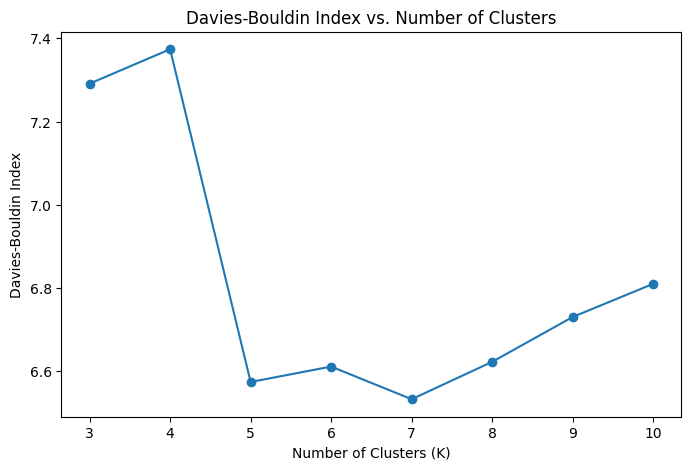

In [51]:
# Plotting K vs. Davies-Bouldin Index
import matplotlib.pyplot as plt

K_values = list(db_dict.keys())
db_indices = list(db_dict.values())

plt.figure(figsize=(8, 5))
plt.plot(K_values, db_indices, marker='o')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.show()

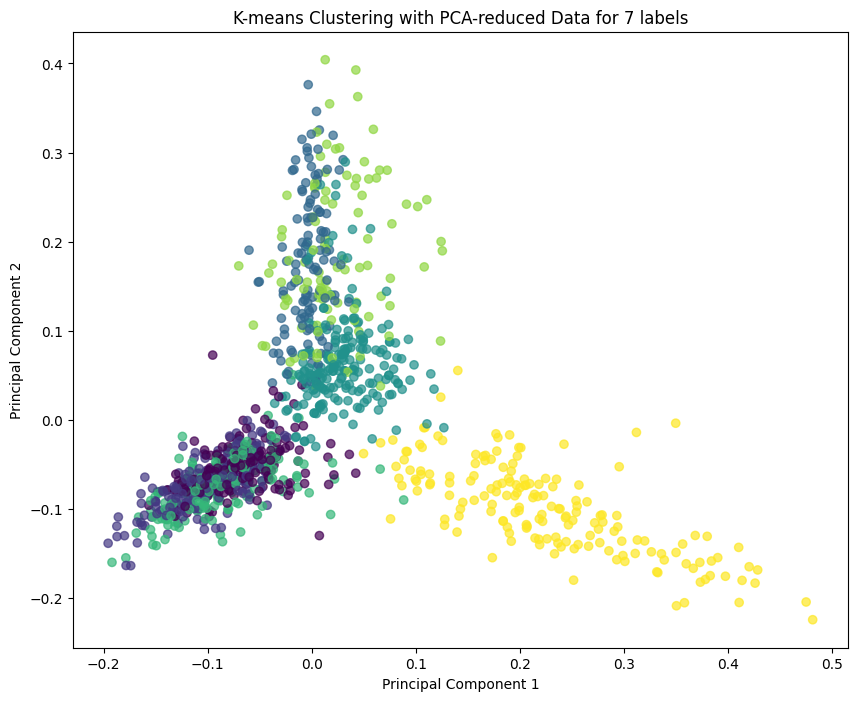

In [52]:
from sklearn.decomposition import PCA

# Reduce the TF-IDF matrix to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())




# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=optimal_labels, cmap='viridis', alpha=0.7)
plt.title(f'K-means Clustering with PCA-reduced Data for {np.unique(optimal_labels).size} labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## cluster digests:


In [53]:
# Get the top unigrams and bigrams for each cluster
from collections import Counter

def print_digests(optimal_cluster, cleaned_documents):
    for cluster_num in range(optimal_cluster):
        # Get indices of documents in the cluster
        cluster_indices = np.where(optimal_labels == cluster_num)[0]
        
        # Get the cleaned documents for these indices
        cluster_docs = [cleaned_documents[i] for i in cluster_indices]
        
        # Join all documents into a single string
        cluster_text = ' '.join(cluster_docs)
        
        # Tokenize the text
        tokens = cluster_text.split()
        
        # Count unigrams
        unigram_counts = Counter(tokens)
        top_unigrams = unigram_counts.most_common(10)
        
        # Count bigrams
        bigrams = zip(tokens, tokens[1:])
        bigram_counts = Counter(bigrams)
        top_bigrams = bigram_counts.most_common(10)
        
        print(f"\nCluster {cluster_num} Digests:")
        print("Top Unigrams:")
        for word, count in top_unigrams:
            print(f"{word}: {count}")
        print("Top Bigrams:")
        for (word1, word2), count in top_bigrams:
            print(f"{word1} {word2}: {count}")


In [54]:
print_digests(optimal_cluster=optimal_cluster, cleaned_documents=cleaned_documents)


Cluster 0 Digests:
Top Unigrams:
the: 2255
and: 1450
of: 1401
to: 907
a: 753
in: 705
for: 565
is: 471
imag: 376
use: 359
Top Bigrams:
of the: 272
comput vision: 195
in the: 160
base on: 111
and the: 106
to the: 82
on the: 81
in thi: 78
the propos: 78
with the: 75

Cluster 1 Digests:
Top Unigrams:
the: 2188
of: 1305
and: 1231
a: 949
to: 946
in: 789
robot: 768
for: 522
with: 378
is: 348
Top Bigrams:
of the: 314
in the: 154
on the: 96
the robot: 85
to the: 84
in a: 81
and the: 78
in thi: 75
of a: 70
for the: 65

Cluster 2 Digests:
Top Unigrams:
the: 1313
of: 818
and: 683
to: 507
a: 489
in: 475
is: 361
for: 298
thi: 205
quantum: 204
Top Bigrams:
of the: 180
in the: 106
in thi: 81
thi paper: 69
to the: 60
quantum comput: 58
the propos: 58
base on: 50
on the: 46
can be: 45

Cluster 3 Digests:
Top Unigrams:
the: 2091
of: 1370
and: 1040
a: 1024
to: 966
in: 763
for: 577
compil: 570
is: 507
we: 367
Top Bigrams:
of the: 289
in the: 161
thi paper: 128
to the: 101
in thi: 96
base on: 80
can be: 78

### Improvement with part c)

trying out a more comprehensive stopword list!

In [55]:

custom_stopwords = {'abstract', 'title', 'method', 'result', 'study', 'approach', 'data', 'using',"propos", "use", "system", "model", "paper", 
    "result", "perform", "base", "show", "present", "propos scheme", "paper propos", "result show", "student", "teacher"}
    

# Initialize the Preprocessor
preprocessor = Preprocessor(documents, custom_stopwords= custom_stopwords)

# Run the full preprocessing pipeline
cleaned_documents = preprocessor.preprocess()






In [56]:

tfidf_vectorizer = TfidfVectorizer(
    # ngram_range: specifies the range of n-grams to extract from the text data
    # (1, 2) means both unigrams and bigrams will be considered
    ngram_range=(1, 2),
    # min_df: minimum document frequency; ignore terms that appear in less than this number of documents
    min_df=5,
    # max_df: maximum document frequency; ignore terms that appear in more than this fraction of documents
    max_df=0.8,
    # stop_words: list of stop words to ignore in the vectorization process
    stop_words=list(stop_words),
    # lowercase: convert all the text to lowercase
    lowercase=True,
    # use_idf: enable inverse-document-frequency reweighting
    use_idf=True,
    # norm: specifies the norm used to normalize the vectors
    # 'l2' is the Euclidean norm, which scales the vectors to unit length
    norm='l2'
)

tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_documents)

feature_names = tfidf_vectorizer.get_feature_names_out()

7


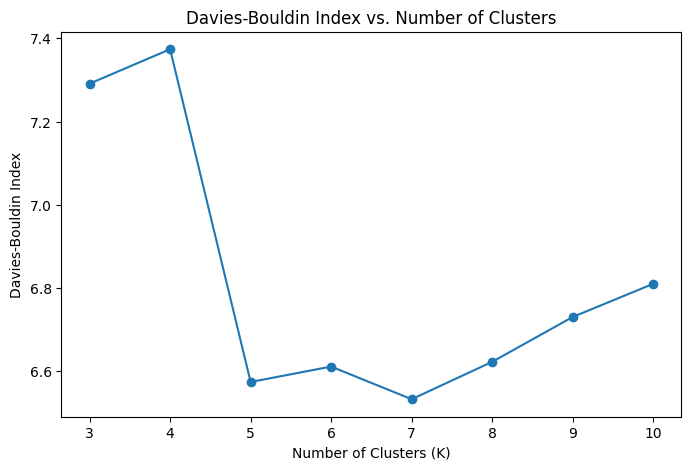

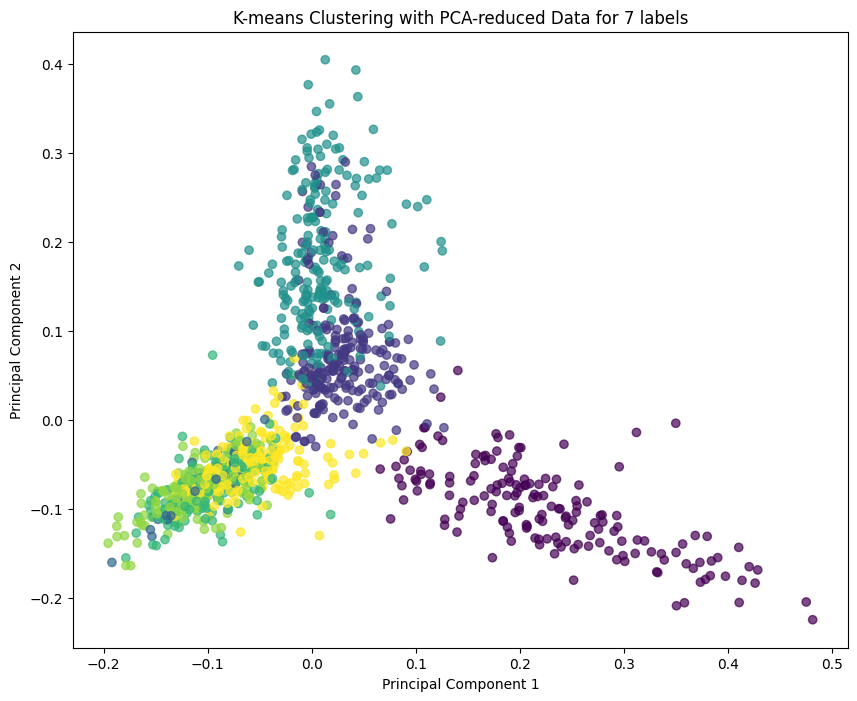

In [57]:
cluster_range = np.arange(3, 11)
db_dict = db_score_clusters(tfidf_matrix=tfidf_matrix, cluster_range=cluster_range)
optimal_cluster = find_optimal_cluster(db_dict=db_dict)
print(optimal_cluster)
optimal_kmeans = KMeans(n_clusters=optimal_cluster)
optimal_kmeans.fit(tfidf_matrix)
optimal_labels = optimal_kmeans.labels_


K_values = list(db_dict.keys())
db_indices = list(db_dict.values())

plt.figure(figsize=(8, 5))
plt.plot(K_values, db_indices, marker='o')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.show()



pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())




# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=optimal_labels, cmap='viridis', alpha=0.7)
plt.title(f'K-means Clustering with PCA-reduced Data for {np.unique(optimal_labels).size} labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [58]:

print_digests(optimal_cluster=optimal_cluster, cleaned_documents=cleaned_documents)


Cluster 0 Digests:
Top Unigrams:
the: 1828
of: 1199
and: 976
a: 793
to: 772
databas: 653
in: 612
data: 522
is: 424
for: 403
Top Bigrams:
relat databas: 237
of the: 219
in the: 145
on the: 85
thi paper: 85
base on: 79
and the: 74
in thi: 74
to the: 72
the databas: 67

Cluster 1 Digests:
Top Unigrams:
the: 2119
of: 1412
a: 1078
and: 1073
to: 1004
in: 774
for: 609
compil: 585
is: 526
we: 381
Top Bigrams:
of the: 296
in the: 158
thi paper: 131
to the: 102
in thi: 97
can be: 82
base on: 80
of a: 80
for the: 72
and the: 66

Cluster 2 Digests:
Top Unigrams:
the: 398
and: 249
of: 231
a: 169
to: 164
track: 157
in: 135
for: 81
is: 73
with: 65
Top Bigrams:
of the: 50
in the: 25
and the: 24
base on: 21
thi paper: 20
on the: 19
object track: 17
track algorithm: 16
in thi: 16
improv the: 16

Cluster 3 Digests:
Top Unigrams:
the: 2641
of: 1457
and: 1348
to: 979
in: 873
a: 860
is: 707
secur: 593
for: 538
thi: 378
Top Bigrams:
of the: 344
in the: 195
the propos: 147
in thi: 138
thi paper: 127
base on: